---
title: "算法交易：制胜策略与原理(欧内斯特·陈)之五"
description: 货币交易与期货交易的均值回归交易策略
author: 王一刀
categories: [算法交易]
date: 2024-09-04
format: html
---

传统的智慧告诉我们：货币和期货是动量型交易者施展才华的领域，而这种传统的智慧所言是正确的。

大多数货币对或期货对是不具有协整属性的，并且由货币或者期货所构建的大部分投资组合都没有表现出横截面式均值回归的特质。因此，在货币和期货交易中，应用均值回归之策略的机会是有限的，但并不是不存在。

### 约翰森检验之特征向量相关的美元/澳元与美元/加元的配对交易

在这里，两种货币之间的对冲比例不是一个值，所以我们不能将其用一个交叉汇率澳元/加元来替代进行相关的交易，同时，我们也不能分别对美元/澳元与加元/美元进行约翰森检验；我们应该对澳元/美元、加元/美元进行约翰森检验，从而使每种金融工具之美元的点数变化标准整齐划一，从直观的角度来说，此种模式也是说得通的，因为就均值回归的交易策略而言，如果加元/美元的价格比澳元/美元的价格低很多的话，那我们就该买入加元。

我们假设输入两个T×1型的数组usdcad与usdaud，其各自代表自身每日的价格系列；T×1型的数组yport代表的是由澳元/美元与加元/美元所构建的投资组合的单位市值，且此市值以美元计价；numUnits代表的相应交易策略要求我们持有的投资组合的数量单位；这里还有一个T×2型的表示相应头寸的数组，其所表示的是我们应该拥有的澳元/美元与加元/美元之以美元计价的相关市值。自然，相应损益表（仍然是以美元计价）是每个金融工具之的市值总和乘以相应的收益率，投资组合的日间收益率等于损益表总值（P&L）除以前一天收盘时投资组合的总市值。


C:\Users\win10\AppData\Local\Temp\ipykernel_20380\4249882280.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  numUnits[t]=-(float(yport.iloc[-1,:])-ma)/mstd


APR=0.064512 Sharpe=1.362926


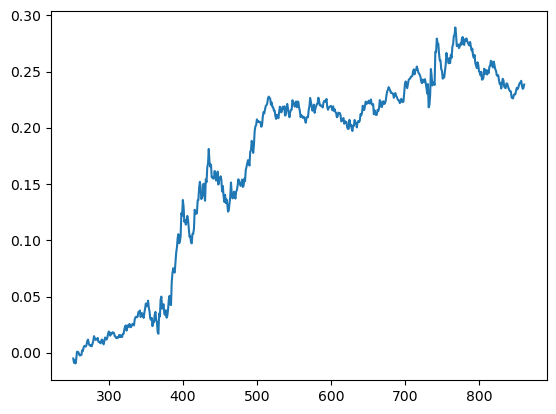

In [3]:
# Example 5.1: Pair Trading USD.AUD vs USD.CAD Using the Johansen Eigenvector

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

df1=pd.read_csv('datas/inputData_USDCAD_20120426.csv')
df1['Date']=pd.to_datetime(df1['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df1.rename(columns={'Close': 'CAD'}, inplace=True)
df1['CAD']=1/df1['CAD']

df2=pd.read_csv('datas/inputData_AUDUSD_20120426.csv')
df2['Date']=pd.to_datetime(df2['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df2.rename(columns={'Close': 'AUD'}, inplace=True)

df=pd.merge(df1, df2, how='inner', on='Date')

df.set_index('Date', inplace=True)

trainlen=250
lookback=20

hedgeRatio=np.full(df.shape, np.NaN)
numUnits=np.full(df.shape[0], np.NaN)

for t in range(trainlen+1, df.shape[0]):
    # Johansen test
    result=vm.coint_johansen(df.values[(t-trainlen-1):t-1], det_order=0, k_ar_diff=1)
    hedgeRatio[t,:]=result.evec[:, 0]
    yport=pd.DataFrame(np.dot(df.values[(t-lookback):t], result.evec[:, 0])) #  (net) market value of portfolio
    ma=yport.mean()
    mstd=yport.std()
    numUnits[t]=-(yport.iloc[-1,:]-ma)/mstd  

positions=pd.DataFrame(np.expand_dims(numUnits, axis=1)*hedgeRatio)*df.values # results.evec(:, 1)' can be viewed as the capital allocation, while positions is the dollar capital in each ETF.
pnl=np.sum((positions.shift().values)*(df.pct_change().values), axis=1)# daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# APR=0.064512 Sharpe=1.362926


交叉货币对交易的一个特色是：如果你持有此货币对的隔夜单，那么，你所收入或支付利差是不同的。我们这里要注意的是：所谓“隔夜”的外汇交易意味着你所持有的头寸要一直延续到或超出美国东部时间的下午5：00点。如果我们持有一个货币对B/Q，且持之隔夜，那相应的利差就是iB-iQ，iB与iQ分别是货币B与回报Q的日利率——如果iQ>iB，那么，这个利差也被称为展期的利息，而此利差实际是一种借息（例如，此项目要计入你账户的借方），实际上，由于相关清算系统运行机制的原因，如果你的买单/空单（对任意交叉货币对儿而言）所持有的时间超过了第T日美国东部时间下午5：00点的话，相应利差就应按T+2日的原则清算，而如果第T日是周末或假日，那相应利差就应按T+3日的原则清算。

### 展期利息相关的澳元/加元的配对交易

这里，我们继续使用线性均值回归的交易策略，但与例5-1相比，为了简单起见，我们选择交易一个现成的货币对澳元/加元，而不是美元/加元和澳元/美元。我们将考虑隔夜的展期利息，因为我们的交易策略之中的头寸持有时间超过美国东部时间5：00点。



APR=0.064719 Sharpe=0.610818


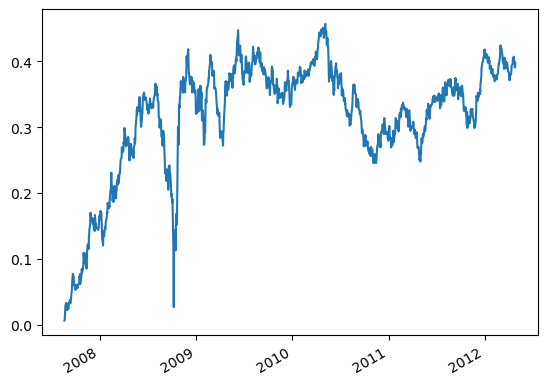

In [8]:
# Example 5.2: Pair Trading AUD.CAD with Rollover Interests

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputData_AUDCAD_20120426.csv')
#df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d')
df.set_index('Date', inplace=True)

aud=pd.read_csv('datas/AUD_interestRate.csv')
audindex=pd.PeriodIndex.from_fields(year=aud.Year, month=aud.Month, freq='M')
#aud.index=audindex.to_timestamp().date
aud.index=audindex.to_timestamp()

cad=pd.read_csv('datas/CAD_interestRate.csv')
cadindex = pd.PeriodIndex.from_fields(year=cad.Year, month=cad.Month, freq='M')
#cad.index=cadindex.to_timestamp().date
cad.index=cadindex.to_timestamp()

df=pd.merge(df, aud, how='outer', left_index=True, right_index=True)
df.drop({'Year', 'Month'}, axis=1, inplace=True)
df.rename({'Rates': 'AUD_Rates'}, axis=1, inplace=True)

df=pd.merge(df, cad, how='outer', left_index=True, right_index=True)
df.drop({'Year', 'Month'}, axis=1, inplace=True)
df.rename({'Rates': 'CAD_Rates'}, axis=1, inplace=True)

# df.fillna(method='ffill', axis=0, inplace=True)
df.ffill(inplace=True)
# df.loc[:,{'AUD_Rates', 'CAD_Rates'}]=df.loc[:,{'AUD_Rates', 'CAD_Rates'}]/365/100 # convert from annual to daily rates
cols = ['AUD_Rates', 'CAD_Rates']  
df[cols] = df[cols] / 365 / 100

isWednesday=df.index.weekday==2
df.loc[isWednesday, 'AUD_Rates'] = df.loc[isWednesday, 'AUD_Rates'] * 3

isThursday=df.index.weekday==3
df.loc[isThursday,'CAD_Rates']=df.loc[isThursday,'CAD_Rates']*3

lookback=20

ma=df['Close'].rolling(lookback).mean()
mstd=df['Close'].rolling(lookback).std()
z=(df['Close']-ma)/mstd  

ret=-np.sign(z).shift()*(np.log(df['Close'])+(-np.log(df['Close'])+np.log(1+df['AUD_Rates'])-np.log(1+df['CAD_Rates'])).shift())
(np.cumprod(1+ret)-1).plot()
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
# APR=0.064719 Sharpe=0.610818


期货合约价格因各种到期日（或“期限”）的不一致而各不相同，它们各自的收益率也有少许的区别。将期限不同的期货合约进行配对，进而交易的模式被称为“跨期套利”。由于跨期套利所对应的标的资产具有两个价格，所以人们会认为此种交易可能为均值回归型的交易策略提供一个良好的机遇，但在现实中，它们不属于一般性质的均值回归交易。

### 现货溢价相较于期货溢价的助记符

这个助记符起源于约翰·梅纳德·凯恩斯（霍尔，1997），他和约翰·希克斯认为：对于真正拥有正常的、实务性的商品的那些人（即“套期保值者”，如农民或石油生产者）来说，他们倾向于通过卖空期货来对冲相应的头寸，冲销其所预期的亏损；与此同时，拥有净多头仓位的投机者也需要补偿相应的敞口风险，所以，他们会只购入连续收益为正值的期货合约，或与期货价格等值的，且低于期货现货价格的预期值的合约，也就是说，此种交易的情境是“现货溢价”式的。所以，我们应该记住“现货溢价”总是与“常态”相伴的，而“常态”就是指期货价格总是低于现货价格。

当然，上述这种说法是不完全正确的，因为我们会发现：原油是一个完美的“常态”商品，而在在各个时期呈现的却是“期货溢价”的形式。但是，上述的解析给了我们一个良好的助记符。

### 以固定收益模型预期现货收益及连续收益

如果我们设定：现货收益率与连续收益率在相应时间序列之内是固定的常数，那么，我们就可以使用线性回归模式来估计它们的值。以前述这种方式，我们会很容易地找到现货收益率的值——我们只需要将现货价格的对数值相对于时间做回归处理即可，但是，如果要发现连续收益率的数值的话，我们就需要选一个固定的时间点，将期限不同的各个期货合约的价格相对于不同的到期日做相应的回归处理。在实践当中，相关的回归系数将取决于固定的时间点，同时取决于当期一组期货合约的价格。所以，尽管我们设定连续收益是常数，但最终我们还是会以预期缓慢变化之γ值的方式来结束相关过程。

我们会将上述的程序应用于价格不同类别的期货，即巴西雷亚尔期货BR、玉米期货C、西得克萨斯（WTI）原油期货CL、铜期货HG、两年期美国国债期货TU。

在下列过程中，我们设定：现货价格包含在一个τ×1型的数组spot之内，期货收盘价数据存储在τ×M数组cl之内，τ是交易日的步长，M是期货合同的数量。当然，不是所有合同在时间序列之内都能够存在，因此，我们将那些不存在的合约所对应的日期标示于数组NaN（NotaNumber）之内。


Average annualized spot return= 0.02805562210100191
Average annualized roll return= -0.1277565022746007


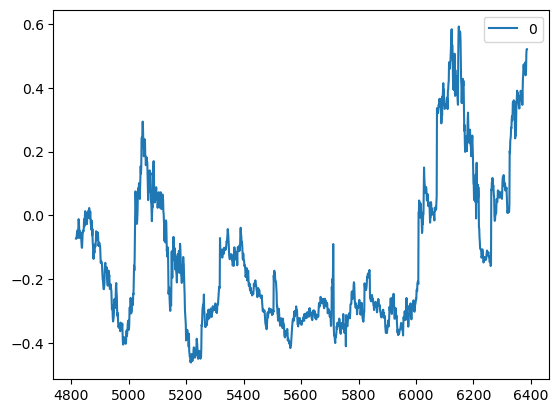

In [10]:
# Example 5.3: Estimating Spot and Roll Returns Using the Constant Returns Model
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm

df=pd.read_csv('datas/inputDataDaily_C2_20120813.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

# Find spot prices
spot=df['C_Spot']
df.drop('C_Spot', axis=1, inplace=True)

T=sm.add_constant(range(spot.shape[0]))

model=sm.OLS(np.log(spot), T)
res=model.fit() # Note this can deal with NaN in top row

print('Average annualized spot return=', 252*res.params.iloc[1])
#Average annualized spot return= 0.02805562210100287

# Fitting gamma to forward curve
gamma=np.full(df.shape[0], np.nan)
for t in range(df.shape[0]):
    idx=np.where(np.isfinite(df.iloc[t, :]))[0]
    idxDiff = np.roll(idx, -1) - idx 
    all_ones = all(idxDiff[0:4]==1) 

    if (len(idx)>=5) and all_ones:
        FT=df.iloc[t, idx[:5]]
        T=sm.add_constant(range(FT.shape[0]))
        model=sm.OLS(np.log(FT.values), T)
        res=model.fit()
        gamma[t]=-12*res.params[1]
          
       
pd.DataFrame(gamma).plot()

print('Average annualized roll return=', np.nanmean(gamma))
# Average annualized roll return= -0.12775650227459556

### 跨期套利具有均值回归属性吗
跨期套利是构建一个投资组合，由一个期货合约的多头和另一个期货合约的空头所组成，且标的资产相同，但到期月份不一样。基于我们之前所掌握的点差，跨期套利似乎是非常适合均值回归交易的可选项，但两个仓位头寸所跟踪的是同一个标的资产吗？在这里，答案为是的。

收益率系列（而不是价格系列）几乎总是具有均值回归的性质。我们正在考虑的不是期货的总收益，而是构成总收益的连续收益率，所以相应情况可能有所不同［尽管式（5-7）所表达模型的前提是现货收益率和连续收益率都是常数，不过，我们可以尝试将其应用于连续收益率是变量的情境之下］。我们以原油期货CL价格之日历价差的对数形式，运行期限为12个月的ADF检验模式，并且发现：相关组合确实是平稳的，且概率为99%，半衰期为36日。此外，如果我们应用正常的线性均值回归策略检测2008年1月2日至2012年8月13日的原油期货CL之日历价差的对数值，我们可以得到一个8.3%的年化收益率，且夏普比率为1.3，


(-4.586684184658414, 0.0001366696053855159, 1, 1995, {'1%': -3.4336320721769433, '5%': -2.862989840784964, '10%': -2.56754183359401})
APR=0.024347 Sharpe=1.275860


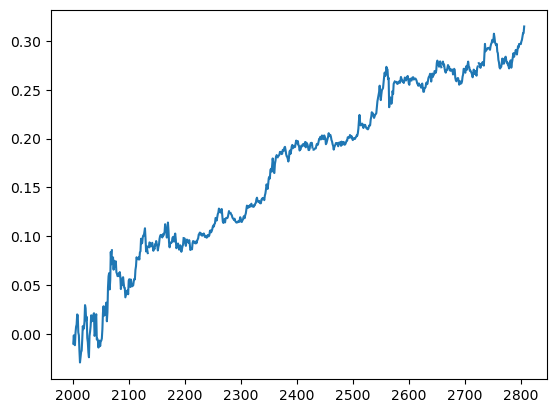

In [12]:
# Example 5.4: Mean Reversion Trading of Calendar Spreads
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


df=pd.read_csv('datas/inputDataDaily_CL_20120502.csv')
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date # remove HH:MM:SS
df.set_index('Date', inplace=True)

# Fitting gamma to forward curve
gamma=np.full(df.shape[0], np.nan)
for t in range(df.shape[0]):
    idx=np.where(np.isfinite(df.iloc[t, :]))[0]
    idxDiff=np.array(list(set(idx[1:])-set(idx)))
    if ((len(idx)>=5) & (all(idxDiff[0:4]==1))):
        FT=df.iloc[t, idx[:5]]
        T=sm.add_constant(range(FT.shape[0]))
        model=sm.OLS(np.log(FT.values), T)
        res=model.fit()
        gamma[t]=-12*res.params[1]
          
results=adfuller(gamma[np.where(np.isfinite(gamma))], maxlag=1, regression='c', autolag=None)
print(results)
#(-4.586684184658408, 0.00013666960538551907, 1, 1995, {'1%': -3.4336320721769433, '5%': -2.862989840784964, '10%': -2.56754183359401})

gamma=pd.DataFrame(gamma)
# gamma.fillna(method='ffill')
gamma.ffill(inplace=True)

#gammaGood=gamma.iloc[np.where(np.isfinite(gamma)), :]
gammaGood=gamma[gamma.notna().values]
gammalag=gammaGood.shift()
deltaGamma=gammaGood-gammalag
deltaGamma=deltaGamma[1:]
gammalag=gammalag[1:]

X=sm.add_constant(gammalag)
model=sm.OLS(deltaGamma, X)
res=model.fit()
halflife=-np.log(2)/res.params.iloc[1]
# 41.095311903707795

lookback=int(halflife)
MA=gamma.rolling(lookback).mean()
MSTD=gamma.rolling(lookback).std()
zScore=(gamma-MA)/MSTD

positions=np.zeros(df.shape)
isExpireDate=np.isfinite(df) & ~np.isfinite(df.shift(-1));
holddays=3*21
numDaysStart=holddays+10
numDaysEnd=10
spreadMonth=12

for c in range(0, df.shape[1]-spreadMonth):
    expireIdx=np.where(isExpireDate.iloc[:,c])[-1]
    if c==0:
        startIdx=max(0, expireIdx-numDaysStart)
        endIdx=expireIdx-numDaysEnd    
    else:
        myStartIdx=endIdx+1
        myEndIdx=expireIdx-numDaysEnd
        if (myEndIdx-myStartIdx >= holddays):
            startIdx=myStartIdx
            endIdx=myEndIdx
        else:
            startIdx=np.Inf
            
    if ((len(expireIdx) > 0) & (endIdx > startIdx)):
        positions[startIdx[0]:endIdx[0], c]=-1
        positions[startIdx[0]:endIdx[0], c+spreadMonth]=1
        
positions[zScore.isna().values.flatten(), :]=0
zScore.fillna(-np.Inf, inplace=True)

positions[zScore.values.flatten() > 0, :]=-positions[zScore.values.flatten() > 0, :]
positions=pd.DataFrame(positions)
df_filled = df.ffill()
pnl=np.sum((positions.shift().values)*(df_filled.pct_change().values), axis=1) # daily P&L of the strategy
ret=pnl/np.sum(np.abs(positions.shift()), axis=1)
(np.cumprod(1+ret)-1).plot()

print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
#APR=0.024347 Sharpe=1.275860
